# Попробуем сделать ансамбль из случ.лесов. Чтобы леса получились максимально разными, будем обучать их на разном признаковом пространстве.

In [1]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost
import matplotlib

In [2]:
data_train = pd.read_csv('train.csv') # Загружаем датасет

In [3]:
# удалим id
data_train.drop(['id'], axis='columns', inplace=True)

### Перемешаем данные

In [4]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)

In [5]:
data_train.head()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
191965,0.295112,0.685823,0.374259,0.235741,0.963687,0.523094,0.573704,0.916726,0.484564,0.509155,0.375363,0.334257,0.578620,0.237291,8.412470
141861,0.514874,0.357070,0.370016,0.439193,0.284877,0.637632,0.531807,0.630240,0.405363,0.741863,0.710572,0.690737,0.809731,0.741665,8.636301
160584,0.332313,0.322988,0.263782,0.458694,0.281011,0.511566,0.513491,0.951896,0.450326,0.530799,0.359212,0.347988,0.745581,0.695061,7.072099
225705,0.508071,0.178606,0.522189,0.350236,0.507641,0.649479,0.794728,0.573104,0.429227,0.379336,0.446899,0.556164,0.351159,0.831453,7.786183
243534,0.351336,0.419173,0.591622,0.798406,0.416610,0.174474,0.261961,0.273847,0.336974,0.188184,0.286560,0.149349,0.375853,0.450801,7.124895


***Выделим признаки***

In [6]:
features = [feature for feature in data_train.columns if feature not in ['target']]

In [7]:
data_test = pd.read_csv('test.csv') # Загружаем датасет тестовый

***Обучаем Random Forest много раз за минусом одного признака***

In [8]:
print(features)

['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


In [9]:
%%time
preds_list = []
for feature in features:
    features_new = features.copy()
    features_new.remove(feature)  # Удаляем один признак, учим на остальных текущий лес
    
    # Обучаем:
    preds_RF = np.zeros(data_test.shape[0])
    kf = KFold(n_splits=3,shuffle=False)  # разделим на 3 фолда
    rmse = []  # список с rmse
    n = 0
    for trn_idx, test_idx in kf.split(data_train[features_new],data_train['target']):
        X_tr,X_val=data_train[features_new].iloc[trn_idx],data_train[features_new].iloc[test_idx]
        y_tr,y_val=data_train['target'].iloc[trn_idx],data_train['target'].iloc[test_idx]
        model = xgboost.XGBRegressor(booster='gbtree', subsample=0.6, learning_rate=1, num_boost_round=1, colsample_bynode=0.6,
                                     num_parallel_tree=150, max_depth=5, tree_method='gpu_hist', verbosity = 0) 
        model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)], verbose = False)
        rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))   # добавляем rmse в список
        print(n+1,rmse[n])                                                            # выводим rmse первого сплита
        n+=1
        preds_RF+=model.predict(data_test[features_new])/kf.n_splits # Добавляем предсказания, усредняем по всем фолдам
    
    preds_list.append(preds_RF)
    print ('Итоговая усредненная точость за минусом признака', feature , ':',np.mean(rmse))

1 0.6990335565922334
2 0.7010489466779305
3 0.7017194692253993
Итоговая усредненная точость за минусом признака cont1 : 0.7006006574985211
1 0.6989970419646516
2 0.7015330519445871
3 0.7016067257018228
Итоговая усредненная точость за минусом признака cont2 : 0.7007122732036871
1 0.6994220199378712
2 0.7016985459154819
3 0.7020064953921803
Итоговая усредненная точость за минусом признака cont3 : 0.7010423537485112
1 0.6999379386630603
2 0.7016122003499429
3 0.7026781469333113
Итоговая усредненная точость за минусом признака cont4 : 0.7014094286487715
1 0.6980013618429943
2 0.7003712123365857
3 0.7012376403360522
Итоговая усредненная точость за минусом признака cont5 : 0.6998700715052107
1 0.6984435172131166
2 0.7008288462062026
3 0.700987572642775
Итоговая усредненная точость за минусом признака cont6 : 0.7000866453540313
1 0.6984390907911722
2 0.7005270116388446
3 0.7008297508751266
Итоговая усредненная точость за минусом признака cont7 : 0.6999319511017145
1 0.697825899131741
2 0.7002

In [10]:
# Посмотрим, какие списки с предсказаниями получились
preds_list[:2]

[array([7.85302305, 7.86228061, 7.89554071, ..., 8.22784424, 8.04083729,
        7.97617292]),
 array([8.00188208, 7.90415215, 7.93615389, ..., 8.14718652, 7.93233132,
        7.98831248])]

***Усредним ответы всех алгоритмов***

In [11]:
preds_sum = np.sum(preds_list, axis = 0)/len(preds_list)

In [12]:
preds_sum

array([7.9259243 , 7.87595829, 7.91890873, ..., 8.18447781, 8.03795172,
       7.953765  ])

In [13]:
sub = pd.read_csv('sample_submission.csv') # csv с ответами
sub['target'] = preds_sum
print(sub.head())
sub.to_csv('RF_minusoneFeature.csv', index=False)

   id    target
0   0  7.925924
1   2  7.875958
2   6  7.918909
3   7  8.239393
4  10  8.155506


### Public score 0.69914

### Попробуем включить в общую модель только наиболее успешные алгоритмы по кросс-валидации, где rmse < 0.70000

***without features: cont12, cont11, cont9, cont8, cont5***

In [14]:
preds_sum_bestmodels = (preds_list[11] + preds_list[10] + preds_list[8] + preds_list[7] + preds_list[4])/5

In [15]:
preds_sum_bestmodels

array([7.91867399, 7.89952374, 7.93116393, ..., 8.18604927, 8.0512816 ,
       7.94791689])

In [16]:
sub = pd.read_csv('sample_submission.csv') # csv с ответами
sub['target'] = preds_sum_bestmodels
print(sub.head())
sub.to_csv('RF_minusoneFeature_bestmodels.csv', index=False)

   id    target
0   0  7.918674
1   2  7.899524
2   6  7.931164
3   7  8.230678
4  10  8.175378


***score 0.69937. Точность упала. Unlucky. Композиция лесов получился менее разнообразный***

## Вглянем ещё раз на target и попробуем менять гиперпараметры лесов.

In [17]:
data_train = pd.read_csv('train.csv') # Загружаем датасет

In [18]:
# удалим id
data_train.drop(['id'], axis='columns', inplace=True)

In [19]:
target = data_train['target']

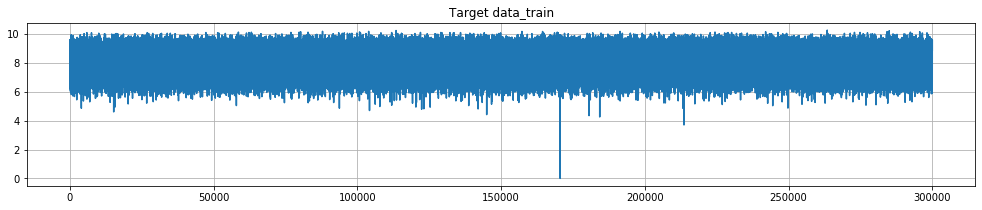

In [20]:
plt.figure(figsize=(17,3))
plt.plot(range(len(target)), target)
plt.title('Target data_train')
plt.grid()

***Видно, что здесь есть очевидный выброс с target = 0. Так же удалим некоторые значения target < 4.5, т.к они так же не очень вписываются в общую картину***

In [21]:
data_train = data_train.drop(np.where(data_train['target'] < 4.5)[0])

In [22]:
target = data_train['target']

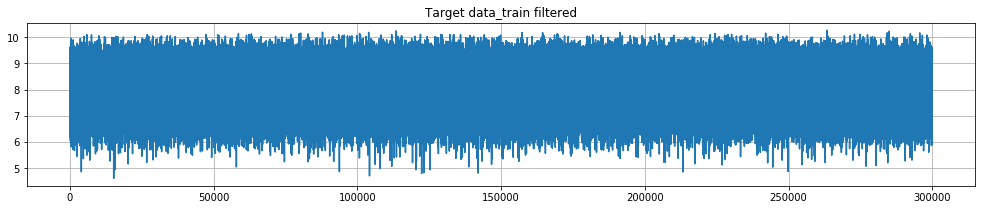

In [23]:
plt.figure(figsize=(17,3))
plt.plot(range(len(target)), target)
plt.title('Target data_train filtered')
plt.grid()

***Выглядит гораздо лучше***

### Перемешаем данные

In [24]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)

In [25]:
data_train.head()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
281588,0.300923,0.313212,0.514111,0.188445,0.284849,0.322177,0.282423,0.362841,0.273637,0.360225,0.236653,0.371517,0.439925,0.562760,8.514869
278985,0.185650,0.422924,0.498046,0.884583,0.397297,0.205564,0.226454,0.773887,0.292944,0.217531,0.211721,0.222196,0.478108,0.315470,8.385677
62590,0.316229,0.357013,0.595943,0.883752,0.876865,0.277072,0.382920,0.567964,0.294842,0.646498,0.421818,0.325825,0.352361,0.254715,6.977938
241183,0.939774,0.421492,0.186348,0.476054,0.283860,0.821030,0.360523,0.813306,0.869228,0.845745,0.691270,0.970108,0.869924,0.727903,8.184020
278453,0.405308,0.773097,0.646606,0.810505,0.541404,0.547825,0.397908,0.497674,0.282534,0.448175,0.407115,0.374206,0.674702,0.394877,7.125937


***Выделим признаки***

In [26]:
features = [feature for feature in data_train.columns if feature not in ['target']]

In [27]:
print ('Признаки', features)

Признаки ['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


In [28]:
data_test = pd.read_csv('test.csv') # Загружаем датасет тестовый

In [29]:
import random
# Для рандомизации лесов будем использовать рандомные гиперпараметры в заданных пределах

***Обучаем Random Forest много раз за минусом одного признака с немного различными гиперпараметрами.***

In [30]:
%%time
preds_list = []
for feature in features:
    features_new = features.copy()
    features_new.remove(feature)  # Удаляем один признак, учим на остальных
    
    random_df = data_train  #
    
    # Обучаем:
    preds_RF = np.zeros(data_test.shape[0])
    kf = KFold(n_splits=3,shuffle=False)  # разделим на 3 фолда
    rmse = []  # list contains rmse for each fold
    n = 0
    subs = cols_bynode = random.randint(55,75)/100
    num_tree = random.randint(80,150)
    
    for trn_idx, test_idx in kf.split(random_df[features_new],random_df['target']):
        X_tr,X_val=random_df[features_new].iloc[trn_idx],random_df[features_new].iloc[test_idx]
        y_tr,y_val=random_df['target'].iloc[trn_idx],random_df['target'].iloc[test_idx]
        model = xgboost.XGBRegressor(booster='gbtree', subsample=subs, learning_rate=1, 
                                     num_boost_round=1, colsample_bynode=cols_bynode,
                                     num_parallel_tree=num_tree, max_depth=5, tree_method='gpu_hist', verbosity = 0) 
        model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)], verbose = False)
        rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))    # добавляем rmse в список
        #print(n+1,rmse[n])                                                            # выводим rmse первого сплита
        n+=1
        preds_RF+=model.predict(data_test[features_new])/kf.n_splits # Добавляем предсказания, усредняем по всем фолдам
    
    preds_list.append(preds_RF)
    print ('colsample_bynode:', cols_bynode, 'num_tree:', num_tree)
    print ('Итоговая усредненная ошибка за минусом признака', feature , ':',np.mean(rmse))

colsample_bynode: 0.56 num_tree: 96
Итоговая усредненная ошибка за минусом признака cont1 : 0.7005002629335434
colsample_bynode: 0.6 num_tree: 150
Итоговая усредненная ошибка за минусом признака cont2 : 0.7004911081433868
colsample_bynode: 0.73 num_tree: 121
Итоговая усредненная ошибка за минусом признака cont3 : 0.7009710719297734
colsample_bynode: 0.72 num_tree: 132
Итоговая усредненная ошибка за минусом признака cont4 : 0.7013742221997955
colsample_bynode: 0.64 num_tree: 131
Итоговая усредненная ошибка за минусом признака cont5 : 0.699764987490167
colsample_bynode: 0.72 num_tree: 121
Итоговая усредненная ошибка за минусом признака cont6 : 0.7000601974776757
colsample_bynode: 0.66 num_tree: 97
Итоговая усредненная ошибка за минусом признака cont7 : 0.6999125767303211
colsample_bynode: 0.62 num_tree: 137
Итоговая усредненная ошибка за минусом признака cont8 : 0.6993501010903352
colsample_bynode: 0.64 num_tree: 146
Итоговая усредненная ошибка за минусом признака cont9 : 0.6996106938529

In [31]:
preds_list[:2]

[array([7.87344098, 7.87162995, 7.8907187 , ..., 8.24238229, 8.04831433,
        7.96301126]),
 array([8.00382662, 7.89826965, 7.93521571, ..., 8.16336989, 7.94339371,
        7.97476482])]

***Усредним ответы всех алгоритмов***

In [32]:
preds_sum = np.sum(preds_list, axis = 0)/len(preds_list)

In [33]:
preds_sum

array([7.94137905, 7.88936872, 7.90588292, ..., 8.1874757 , 8.0508947 ,
       7.94792535])

In [34]:
sub = pd.read_csv('sample_submission.csv') # csv с ответами
sub['target'] = preds_sum
print(sub.head())
sub.to_csv('RF_minusoneFeature_V2_1.csv', index=False)

   id    target
0   0  7.941379
1   2  7.889369
2   6  7.905883
3   7  8.264016
4  10  8.144817


***score 0.69935 Unlucky (best RF 69914)***